In [1]:
## initiation 1210

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import constrNMPy
import os 
import warnings

from matplotlib import gridspec
from scipy import sparse, special, stats

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)

# color pallette
[gr,ye,re,bl,pu,ir,ak] = ['#8ECFC9', '#FFBE7A', '#FA7F6F', '#82B0D2','#BEB8DC', '#E7DAD2','#999999']
[vio, grb, lig, sil, aqua] = ['#8c84cf','#6699CC','#66CC99','#C0C0C0','#6db3bc']
# set the style of the plots
az.style.use("arviz-white")

from statistics import mean, stdev
from math import sqrt

# 1 Load Data & Screening

16 10 3 16 16 17 11 19 14 12 15 15 18 6 18 13 23 16 8 12 22 16 18 22 14 12 18 16 20 23 9 12 

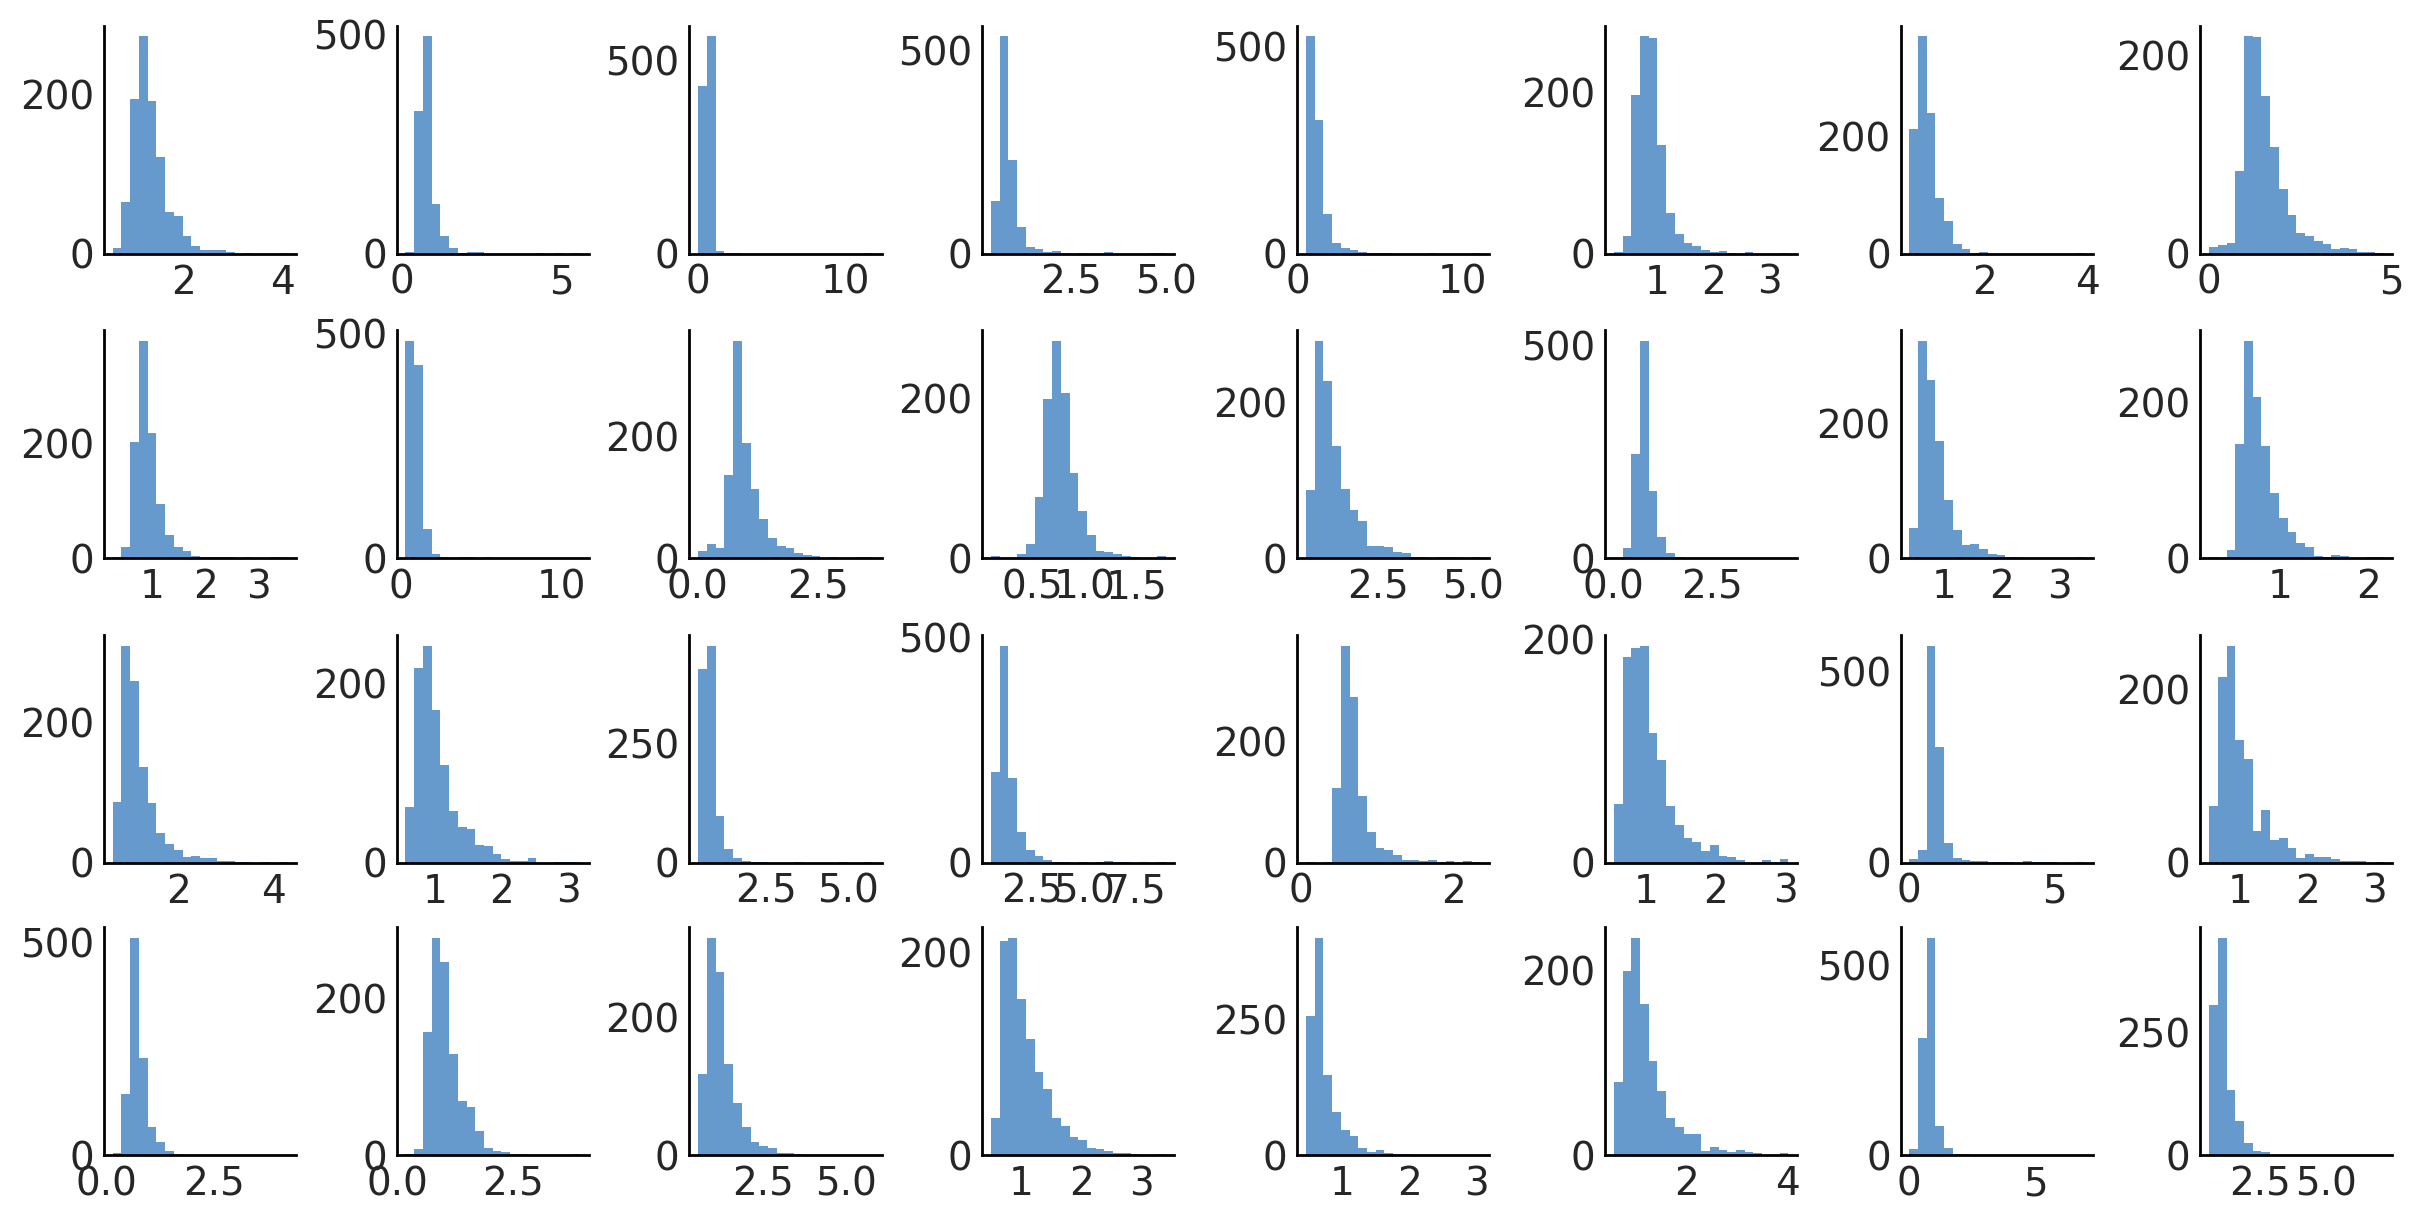

In [2]:
import dill

# load data
with open('./all_data.pkl', 'rb') as f:
    all_data = dill.load(f)  # obj = dill.load(file)
    
maxsubj = 32; maxblock = 20; maxtrial = 50
plt.figure(figsize=(12, 6))

for iS in range(1, maxsubj + 1):
    subject_data = all_data[iS]  # all blocks for this subject
    temp_RT = []
    temp_count = 0
    ## calculate RT mean and SD for each subject
    for iB in range(1, maxblock + 1):
        key = f"{iB}_block"
        block_data = subject_data[iB - 1]  # read current block
        temp_RT.append(block_data['RT'])
    temp_RT = np.concatenate(temp_RT)
    ## Screening data by 3 SD from the mean
    for iB in range(1, maxblock + 1):
        key = f"{iB}_block"
        block_data = subject_data[iB - 1]
        all_data[iS][iB - 1]['Qualified'] = np.logical_and(block_data['RT'] > mean(temp_RT) - 3 * stdev(temp_RT),
                                                           block_data['RT'] < mean(temp_RT) + 3 * stdev(temp_RT))
        temp_count += np.sum(all_data[iS][iB - 1]['Qualified'])
    print(1000 - temp_count, end=' ') 
    plt.subplot(4, 8, iS)
    plt.hist(temp_RT, bins=20, color=grb)
plt.show()

## 1.2 Shifting Contrast

由于实验中 "ContrastSeq" 一栏记录的其实是下一试次的对比度，所以需要将其向上移动一行，便于后续的分析。

同时，由于在实验过程中可以整体观察到阈值的降低，所以将 Contrast 在每一个 block 中进行归一化可以更好地进行 Logistics 回归。

In [5]:
maxsubj = 32 ;maxblock = 20 ;maxtrial = 50

def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

all_data_contrast = all_data.copy()

for iS in range(1, maxsubj + 1):
    subject_data = all_data_contrast[iS]
    for iB in range(maxblock):
        block_data = subject_data[iB]
        block_data['ContrastSeq'] = normalize(block_data['ContrastSeq'])
        block_data['ContrastSeq'] = block_data['ContrastSeq'].shift(1)


# 2 Probabilistic Choice Model

Currently we have the following assumptions:

- The probability of choosing the certain is a logistic function of the sensory/decisional evidence of the certain option.

And we have to run the model of perceptual level and decisional level separately.

## 2.1 PSE shift in Current Regression

### 2.1.1 Perceptual Level

We assume the 45deg ori is the Target orientation.

In [8]:
# Realign the data
subject_data = all_data_contrast[1].copy()
block_data = all_data_contrast[1][2].copy()
block_data.head()

,ContrastSeq,StimSeq,RespOri,RespLorR,Accuracy,RT,ProbeOriLeft,ProbeOriRight,Qualified
0,NaN,-45,45,-1,0,1.666601,45,-45,True
1,0.434821,-45,45,1,0,1.198847,-45,45,True
2,0.556758,45,45,-1,1,1.101904,45,-45,True
3,0.515422,-45,45,-1,0,1.099278,45,-45,True
4,0.634382,45,45,1,1,0.800002,-45,45,True


In [36]:


# Combining all blocks for each subject
for iB in range(maxblock):
    block_data = subject_data[iB]
    Curr_resp = block_data['RespOri'] / 45
    Curr_Sen = block_data['ContrastSeq'] * (block_data['StimSeq'] / 45)
    Prev_Ori = block_data['RespOri'].shift(1) / 45
    test_regression = pd.DataFrame({'Curr_Sen': Curr_Sen, 'Curr_resp': Curr_resp, 'Constant': 1, 'Prev_Ori': Prev_Ori})
    test_regression['Curr_resp'].replace(-1, 0, inplace=True)
    test_regression = test_regression.dropna()
    if iB == 0:
        temp_data = test_regression
    else:
        temp_data = pd.concat([temp_data, test_regression], ignore_index=True)

# Logistic regression
import statsmodels.api as sm

temp_regression_prev_45 = temp_data[temp_data['Prev_Ori'] == 1]
temp_regression_prev_n45 = temp_data[temp_data['Prev_Ori'] == -1]

logit_model_prev_45 = sm.Logit(temp_regression_prev_45['Curr_resp'], temp_regression_prev_45[['Curr_Sen', 'Constant']])
result_prev_45 = logit_model_prev_45.fit()
print(result_prev_45.summary2())

logit_model_prev_n45 = sm.Logit(temp_regression_prev_n45['Curr_resp'], temp_regression_prev_n45[['Curr_Sen', 'Constant']])
result_prev_n45 = logit_model_prev_n45.fit()
print(result_prev_n45.summary2())

logit_model_average = sm.Logit(temp_data['Curr_resp'], temp_data[['Curr_Sen', 'Constant']])
result_average = logit_model_average.fit()
print(result_average.summary2())



Optimization terminated successfully.
         Current function value: 0.494247
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.234     
Dependent Variable: Curr_resp        AIC:              592.1545  
Date:               2023-12-10 14:46 BIC:              600.9316  
No. Observations:   595              Log-Likelihood:   -294.08   
Df Model:           1                LL-Null:          -383.82   
Df Residuals:       593              LLR p-value:      6.2821e-41
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-------------------------------------------------------------------
             Coef.    Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
Curr_Sen     2.3016     0.2045   11.2529   0.0000   1.9007   2.7024
Constant     0.8418     0.1091    7.7130   0.0000   0.6279

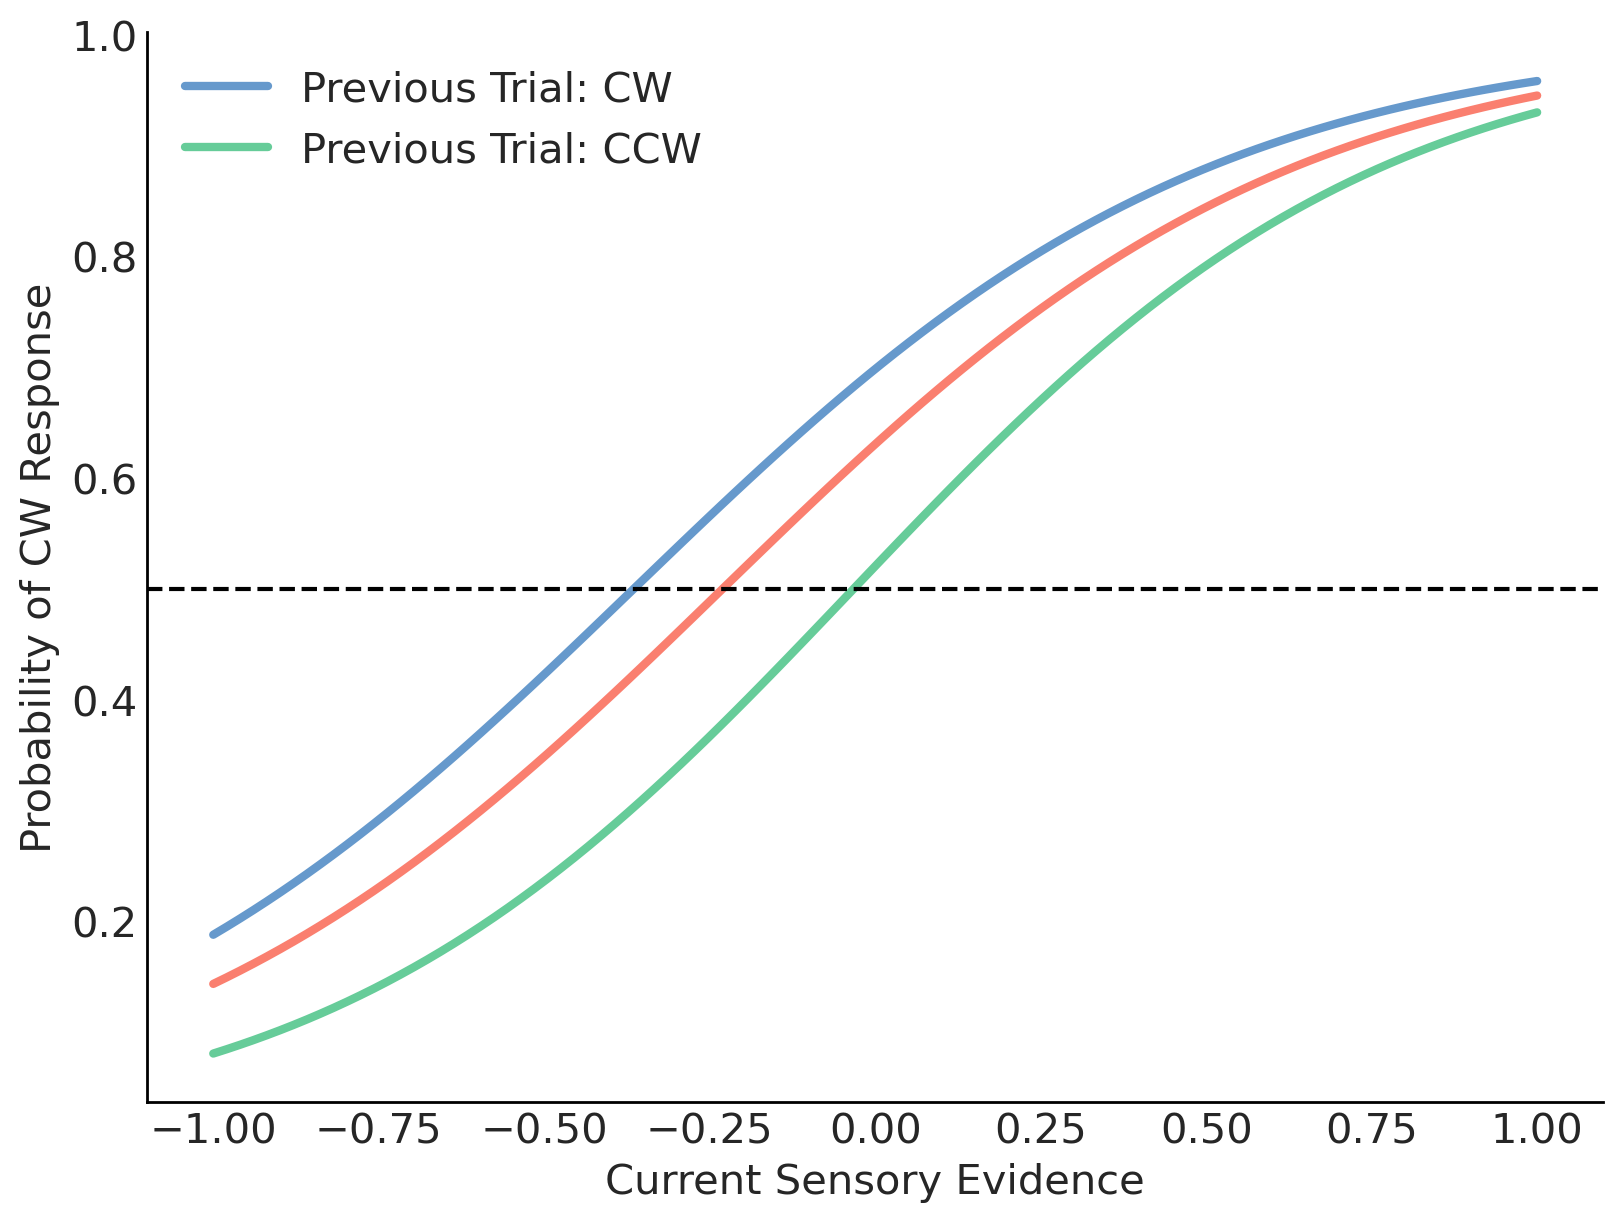

In [38]:
# draw out the logit function
plt.figure(figsize=(8, 6))
x = np.linspace(-1, 1, 100)
y1 = np.exp(result_prev_45.params[0] * x + result_prev_45.params[1]) / (1 + np.exp(result_prev_45.params[0] * x + result_prev_45.params[1]))
y2 = np.exp(result_prev_n45.params[0] * x + result_prev_n45.params[1]) / (1 + np.exp(result_prev_n45.params[0] * x + result_prev_n45.params[1]))
y3 = np.exp(result_average.params[0] * x + result_average.params[1]) / (1 + np.exp(result_average.params[0] * x + result_average.params[1]))
plt.plot(x, y1, color=grb, linewidth=3)
plt.plot(x, y2, color=lig, linewidth=3)
plt.plot(x, y3, color=re, linewidth=3)
plt.legend(['Previous Trial: CW', 'Previous Trial: CCW'], fontsize=15)
plt.axhline(y=0.5, color='k', linestyle='--')
plt.xlabel('Current Sensory Evidence', fontsize=15)
plt.ylabel('Probability of CW Response', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()



### 2.1,2 Motor Level

We assume the RightKey is the Target direction.

In [39]:
subject_data = all_data_contrast[1].copy()
block_data = all_data_contrast[1][2].copy()
block_data.head()

,ContrastSeq,StimSeq,RespOri,RespLorR,Accuracy,RT,ProbeOriLeft,ProbeOriRight,Qualified
0,NaN,-45,45,-1,0,1.666601,45,-45,True
1,0.434821,-45,45,1,0,1.198847,-45,45,True
2,0.556758,45,45,-1,1,1.101904,45,-45,True
3,0.515422,-45,45,-1,0,1.099278,45,-45,True
4,0.634382,45,45,1,1,0.800002,-45,45,True


In [56]:
# Realign the data
subject_data = all_data_contrast[1].copy()
block_data = all_data_contrast[1][2].copy()

# Combining all blocks for each subject
for iB in range(maxblock):
    block_data = subject_data[iB]
    Curr_resp_motor = block_data['RespLorR']
    Curr_resp_motor.replace(-1, 0, inplace=True)
    Curr_Sen_motor = block_data['ContrastSeq'] * (block_data['StimSeq'] / block_data['ProbeOriRight'])
    Prev_resp_motor = block_data['RespLorR'].shift(1)
    test_regression = pd.DataFrame({'Curr_Sen_motor': Curr_Sen_motor, 'Curr_resp_motor': Curr_resp_motor, 'Constant': 1, 'Prev_resp_motor': Prev_resp_motor})
    test_regression = test_regression.dropna()
    if iB == 0:
        temp_data = test_regression
    else:
        temp_data = pd.concat([temp_data, test_regression], ignore_index=True)

# Logistic regression
import statsmodels.api as sm

temp_regression_prev_R = temp_data[temp_data['Prev_resp_motor'] == 1]
temp_regression_prev_L = temp_data[temp_data['Prev_resp_motor'] == 0]

logit_model_prev_R = sm.Logit(temp_regression_prev_R['Curr_resp_motor'], temp_regression_prev_R[['Curr_Sen_motor', 'Constant']])
result_prev_R = logit_model_prev_R.fit()
print(result_prev_R.summary2())

logit_model_prev_L = sm.Logit(temp_regression_prev_L['Curr_resp_motor'], temp_regression_prev_L[['Curr_Sen_motor', 'Constant']])
result_prev_L = logit_model_prev_L.fit()
print(result_prev_L.summary2())

logit_model_average = sm.Logit(temp_data['Curr_resp_motor'], temp_data[['Curr_Sen_motor', 'Constant']])
result_average = logit_model_average.fit()
print(result_average.summary2())




Optimization terminated successfully.
         Current function value: 0.553165
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.201     
Dependent Variable: Curr_resp_motor  AIC:              518.4438  
Date:               2023-12-10 15:52 BIC:              526.7278  
No. Observations:   465              Log-Likelihood:   -257.22   
Df Model:           1                LL-Null:          -321.93   
Df Residuals:       463              LLR p-value:      5.5257e-30
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
-----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------
Curr_Sen_motor      2.0474   0.2055  9.9644 0.0000  1.6447 2.4502
Constant           -0.0776   0.1077 -0.7207 0.4711 -0.2888 0.1335


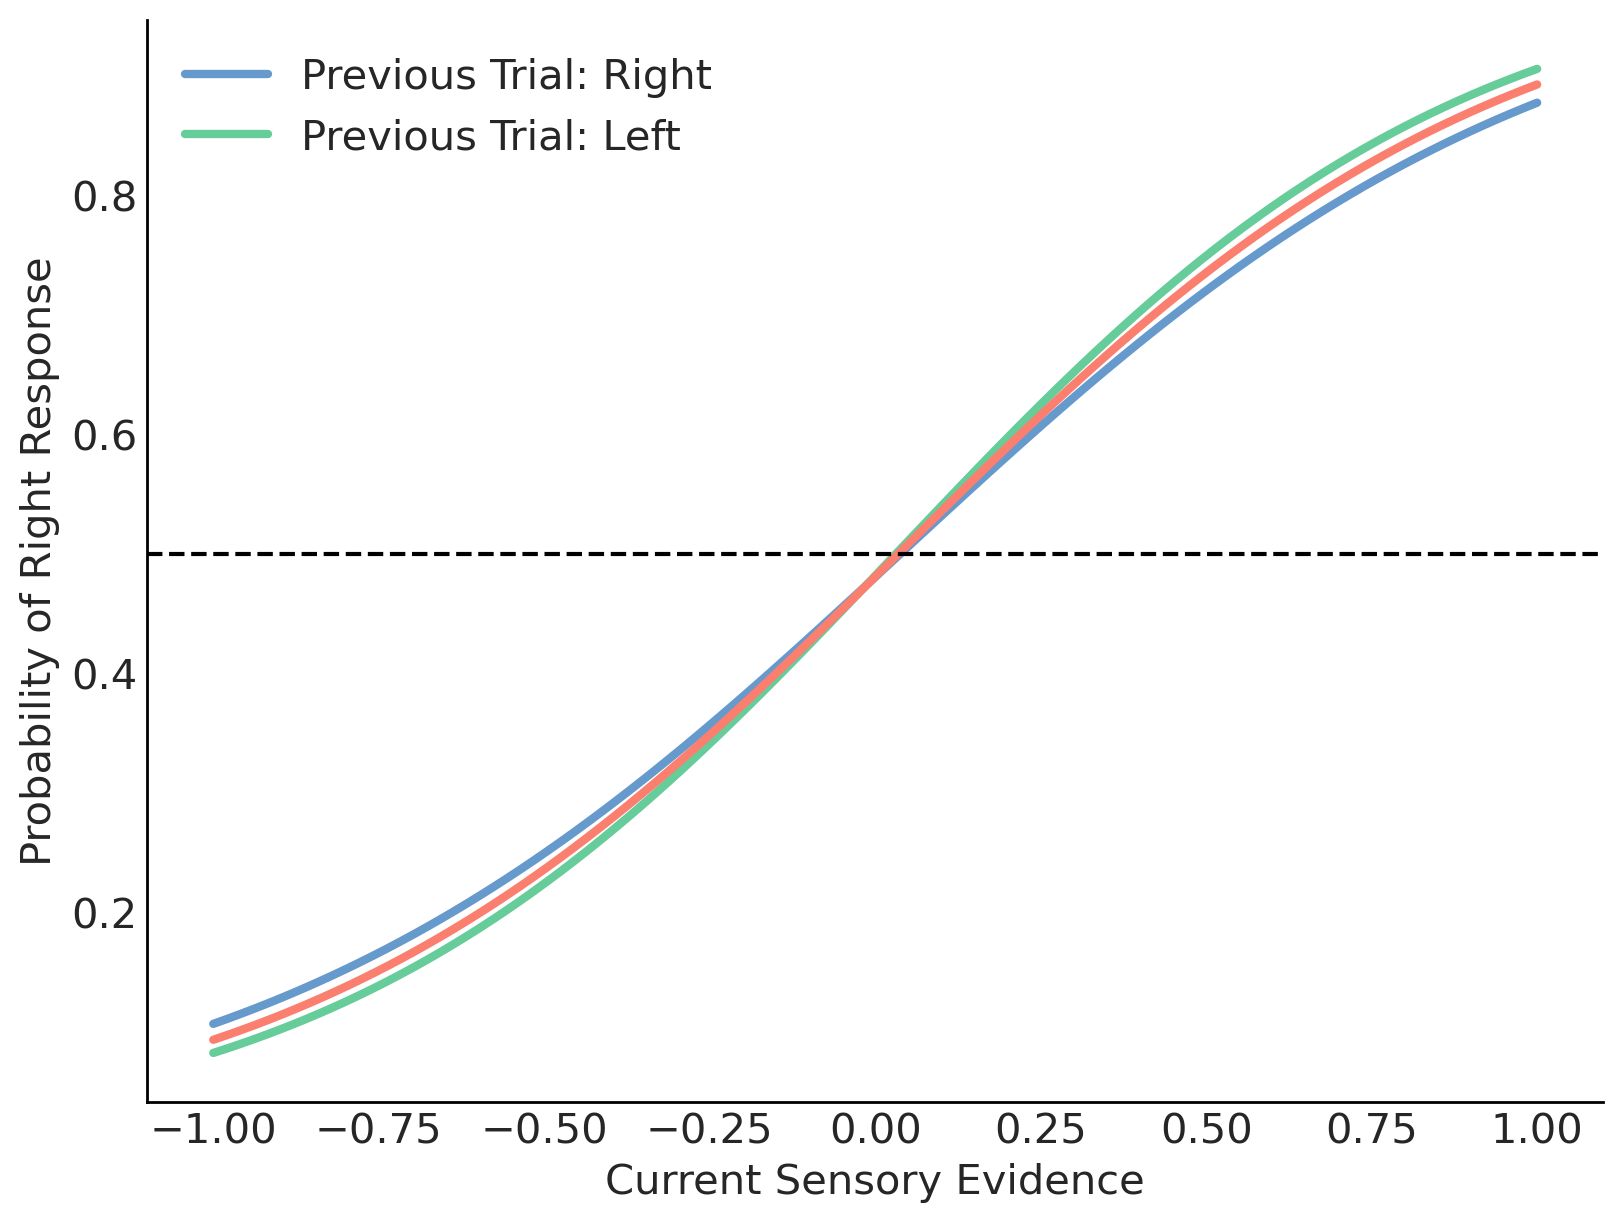

In [57]:
# draw out the logit function
plt.figure(figsize=(8, 6))
x = np.linspace(-1, 1, 100)
y1 = np.exp(result_prev_R.params[0] * x + result_prev_R.params[1]) / (1 + np.exp(result_prev_R.params[0] * x + result_prev_R.params[1]))
y2 = np.exp(result_prev_L.params[0] * x + result_prev_L.params[1]) / (1 + np.exp(result_prev_L.params[0] * x + result_prev_L.params[1]))
y3 = np.exp(result_average.params[0] * x + result_average.params[1]) / (1 + np.exp(result_average.params[0] * x + result_average.params[1]))
plt.plot(x, y1, color=grb, linewidth=3)
plt.plot(x, y2, color=lig, linewidth=3)
plt.plot(x, y3, color=re, linewidth=3)
plt.legend(['Previous Trial: Right', 'Previous Trial: Left'], fontsize=15)
plt.axhline(y=0.5, color='k', linestyle='--')
plt.xlabel('Current Sensory Evidence', fontsize=15)
plt.ylabel('Probability of Right Response', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()


In [58]:
# save the data

import dill
dill.dump_session('logistic_regression_1210.db')